# RealNVP
Implemented using normflows package https://github.com/VincentStimper/normalizing-flows, a compilation of pytorch implementations for popular flow models

This notebook illustrates how to use the `normflows` packages by training a simple Real NVP model to a 2D distribution consisting on two half moons.

Before we can start, we have to install the package.

### Imports and setup

In [1]:
!pip install normflows

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import required packages
import torch
import torch.nn as nn

import numpy as np
import normflows as nf
from normflows import distributions
from normflows import utils

from matplotlib import pyplot as plt

import math
import os

import time, tqdm
from tqdm import trange

After importing the required packages, we want to create a `nf.NormalizingFlow` model. Therefore, we need a base distribution, which we set to be a Gaussian, and a list of flow layers. The flow layers are simply affine coupling layers, whereby `nf.AffineCouplingBlock` already includes the splitting and merging of the features as it is done in coupling. We also swap the features after each layer to ensure that they are all modified.

In [3]:
!ls ../

bin	 dev   lib32   mnt			 python-apt  srv    usr
boot	 etc   lib64   NGC-DL-CONTAINER-LICENSE  root	     sys    var
content  home  libx32  opt			 run	     tmp
datalab  lib   media   proc			 sbin	     tools


## Data

In [4]:
def two_spirals(n_samples=8000):
    z = torch.randn(n_samples, 2)
    n = torch.sqrt(torch.rand(n_samples // 2)) * 540 * (2 * math.pi) / 360
    d1x = - torch.cos(n) * n + torch.rand(n_samples // 2) * 0.5
    d1y =   torch.sin(n) * n + torch.rand(n_samples // 2) * 0.5
    x = torch.cat([torch.stack([ d1x,  d1y], dim=1),
                    torch.stack([-d1x, -d1y], dim=1)], dim=0) / 3
    X = x + 0.1*z
    # return TensorDataset(X)
    return X

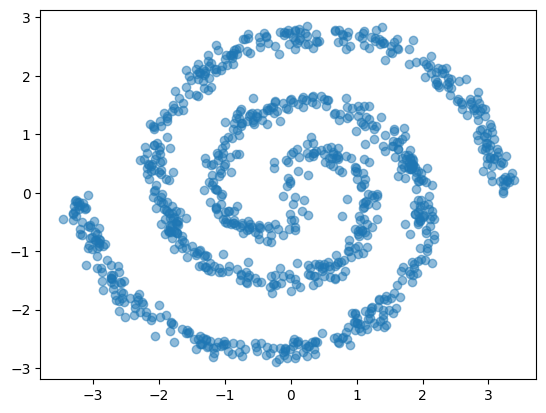

In [5]:
x_sample = two_spirals(1000)

plt.scatter(x_sample[:, 0], x_sample[:, 1], alpha=0.5)

## Model

In [6]:
class NormalizingFlow(nn.Module):
    """
    Normalizing Flow model to approximate target distribution
    """

    def __init__(self, q0, flows, p=None):
        """Constructor
        Args:
          q0: Base distribution
          flows: List of flows
          p: Target distribution
        """
        super().__init__()
        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def forward(self, z):
        """Transforms latent variable z to the flow variable x
        Args:
          z: Batch in the latent space
        Returns:
          Batch in the space of the target distribution
        """
        for flow in self.flows:
            z, _ = flow(z)
        return z

    def forward_and_log_det(self, z):
        """Transforms latent variable z to the flow variable x and
        computes log determinant of the Jacobian
        Args:
          z: Batch in the latent space
        Returns:
          Batch in the space of the target distribution,
          log determinant of the Jacobian
        """
        log_det = torch.zeros(len(z), device=z.device)
        for flow in self.flows:
            z, log_d = flow(z)
            log_det -= log_d
        return z, log_det

    def inverse(self, x):
        """Transforms flow variable x to the latent variable z
        Args:
          x: Batch in the space of the target distribution
        Returns:
          Batch in the latent space
        """
        for i in range(len(self.flows) - 1, -1, -1):
            x, _ = self.flows[i].inverse(x)
        return x

    def inverse_and_log_det(self, x):
        """Transforms flow variable x to the latent variable z and
        computes log determinant of the Jacobian
        Args:
          x: Batch in the space of the target distribution
        Returns:
          Batch in the latent space, log determinant of the
          Jacobian
        """
        log_det = torch.zeros(len(x), device=x.device)
        for i in range(len(self.flows) - 1, -1, -1):
            x, log_d = self.flows[i].inverse(x)
            log_det += log_d
        return x, log_det

    def forward_kld(self, x):
        """Estimates forward KL divergence, see [arXiv 1912.02762](https://arxiv.org/abs/1912.02762)
        Args:
          x: Batch sampled from target distribution
        Returns:
          Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return -torch.mean(log_q)

    def reverse_kld(self, num_samples=1, beta=1.0, score_fn=True):
        """Estimates reverse KL divergence, see [arXiv 1912.02762](https://arxiv.org/abs/1912.02762)
        Args:
          num_samples: Number of samples to draw from base distribution
          beta: Annealing parameter, see [arXiv 1505.05770](https://arxiv.org/abs/1505.05770)
          score_fn: Flag whether to include score function in gradient, see [arXiv 1703.09194](https://arxiv.org/abs/1703.09194)
        Returns:
          Estimate of the reverse KL divergence averaged over latent samples
        """
        z, log_q_ = self.q0(num_samples)
        log_q = torch.zeros_like(log_q_)
        log_q += log_q_
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        if not score_fn:
            z_ = z
            log_q = torch.zeros(len(z_), device=z_.device)
            utils.set_requires_grad(self, False)
            for i in range(len(self.flows) - 1, -1, -1):
                z_, log_det = self.flows[i].inverse(z_)
                log_q += log_det
            log_q += self.q0.log_prob(z_)
            utils.set_requires_grad(self, True)
        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)

    def reverse_alpha_div(self, num_samples=1, alpha=1, dreg=False):
        """Alpha divergence when sampling from q
        Args:
          num_samples: Number of samples to draw
          dreg: Flag whether to use Double Reparametrized Gradient estimator, see [arXiv 1810.04152](https://arxiv.org/abs/1810.04152)
        Returns:
          Alpha divergence
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        log_p = self.p.log_prob(z)
        if dreg:
            w_const = torch.exp(log_p - log_q).detach()
            z_ = z
            log_q = torch.zeros(len(z_), device=z_.device)
            utils.set_requires_grad(self, False)
            for i in range(len(self.flows) - 1, -1, -1):
                z_, log_det = self.flows[i].inverse(z_)
                log_q += log_det
            log_q += self.q0.log_prob(z_)
            utils.set_requires_grad(self, True)
            w = torch.exp(log_p - log_q)
            w_alpha = w_const**alpha
            w_alpha = w_alpha / torch.mean(w_alpha)
            weights = (1 - alpha) * w_alpha + alpha * w_alpha**2
            loss = -alpha * torch.mean(weights * torch.log(w))
        else:
            loss = np.sign(alpha - 1) * torch.logsumexp(alpha * (log_p - log_q), 0)
        return loss

    def sample(self, num_samples=1):
        """Samples from flow-based approximate distribution
        Args:
          num_samples: Number of samples to draw
        Returns:
          Samples, log probability
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q

    def log_prob(self, x):
        """Get log probability for batch
        Args:
          x: Batch
        Returns:
          log probability
        """
        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return log_q

    def save(self, path):
        """Save state dict of model
        Args:
          path: Path including filename where to save model
        """
        torch.save(self.state_dict(), path)

    def load(self, path):
        """Load model from state dict
        Args:
          path: Path including filename where to load model from
        """
        self.load_state_dict(torch.load(path))

## Set up model

In [7]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = NormalizingFlow(base, flows)

In [8]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

## Visualizations
Here we define the dataset used for trarining, plot the corresponding target distribution (if we have it), some true samples (TODO), and the initial flow distribution (diagonal Gaussian)

Define mesh grid for 2D plotting

In [9]:
x_lim_plot = (-4, 4)
y_lim_plot = (-4, 4)

# Define mesh grid
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(x_lim_plot[0], x_lim_plot[1], grid_size), torch.linspace(y_lim_plot[0], y_lim_plot[1], grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Define and plot 2D target distribution

In [10]:
# Define target distribution
# target = nf.distributions.TwoMoons()

In [11]:
# # Plot target distribution
# log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
# prob = torch.exp(log_prob)
# prob[torch.isnan(prob)] = 0

# plt.figure(figsize=(6, 6))
# plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')
# plt.gca().set_aspect('equal', 'box')
# plt.show()

Plot initial flow 2D base distribution (Gaussian)

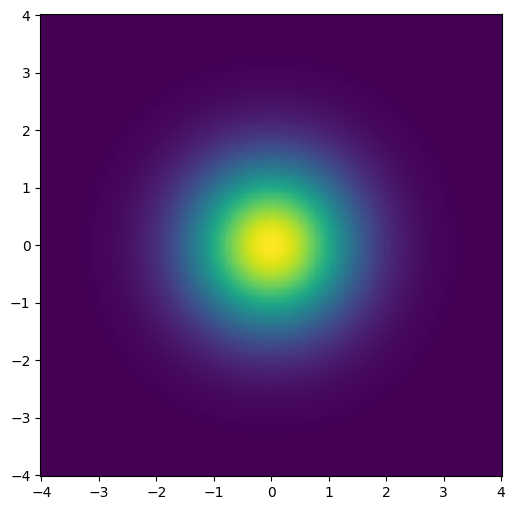

In [12]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(6, 6))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Execute Taining

Now, we are ready to train the flow model. This can be done in a similar fashion as standard neural networks. Since we use samples from the target for training, we use the forward KL divergence as objective, which is equivalent to maximum likelihood.

 10%|▉         | 798/8000 [00:47<05:33, 21.56it/s]

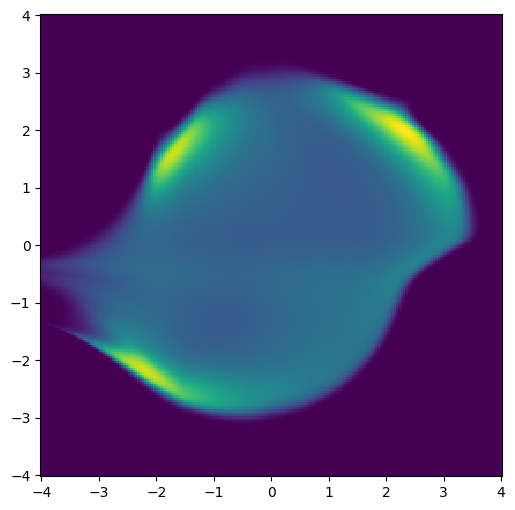

 20%|█▉        | 1598/8000 [01:29<05:08, 20.76it/s]

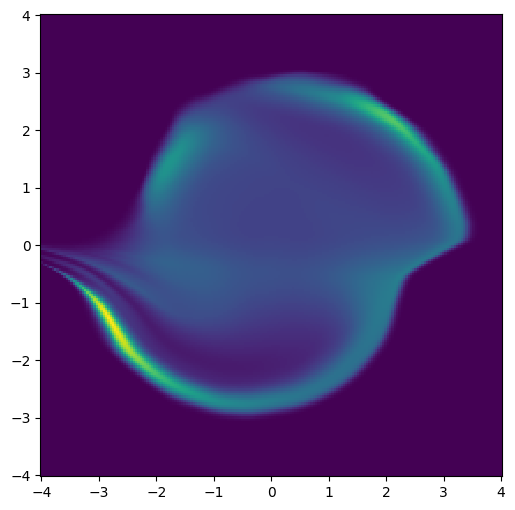

 30%|██▉       | 2398/8000 [02:11<04:34, 20.37it/s]

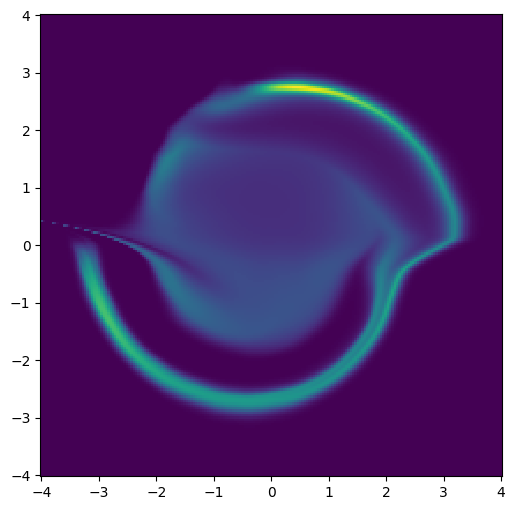

 40%|███▉      | 3198/8000 [02:53<03:53, 20.57it/s]

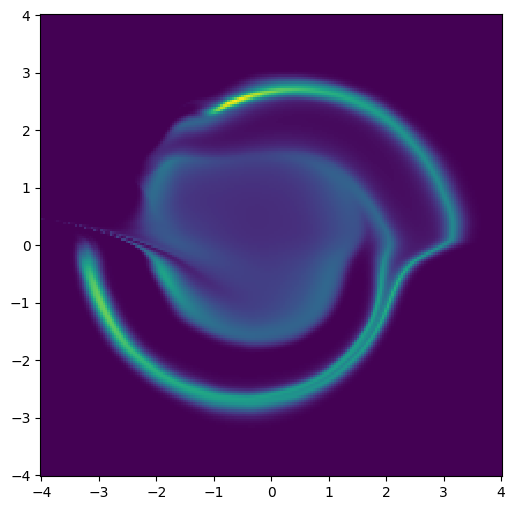

 50%|████▉     | 3998/8000 [03:36<03:44, 17.80it/s]

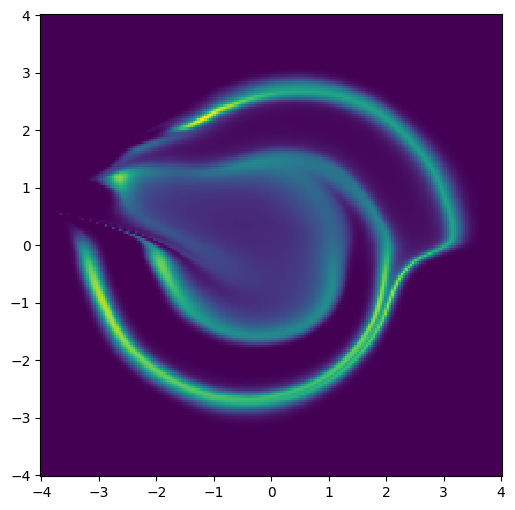

 60%|█████▉    | 4798/8000 [04:17<02:34, 20.78it/s]

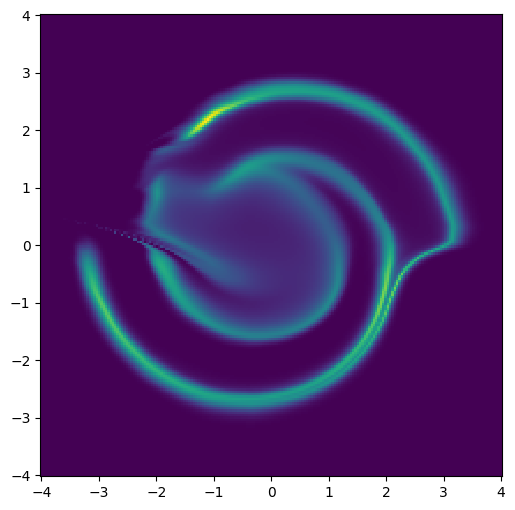

 70%|██████▉   | 5599/8000 [04:59<01:57, 20.47it/s]

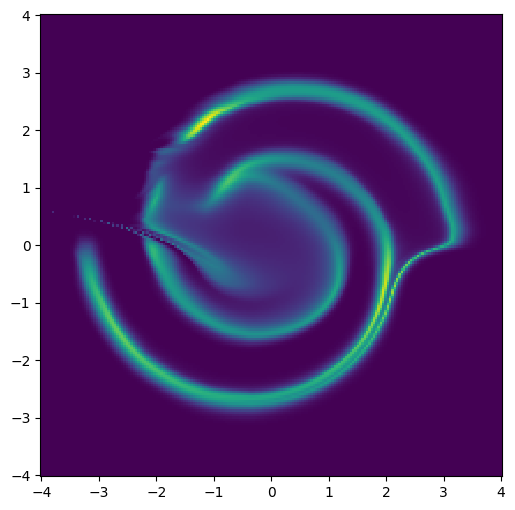

 80%|███████▉  | 6399/8000 [05:41<01:19, 20.17it/s]

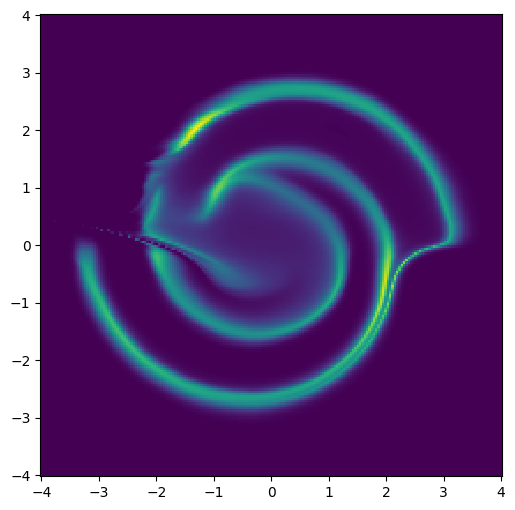

 90%|████████▉ | 7199/8000 [06:23<00:40, 20.00it/s]

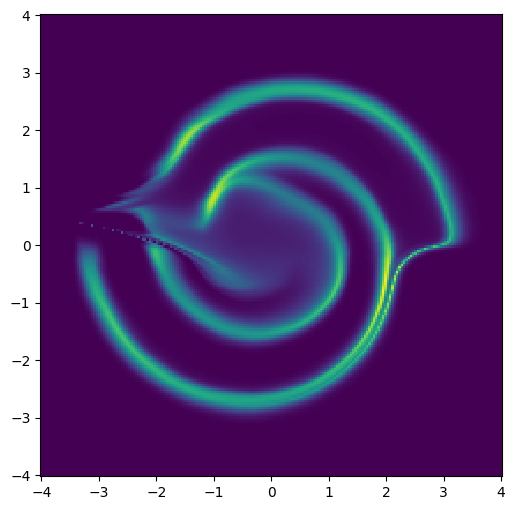

100%|█████████▉| 7998/8000 [07:07<00:00, 18.84it/s]

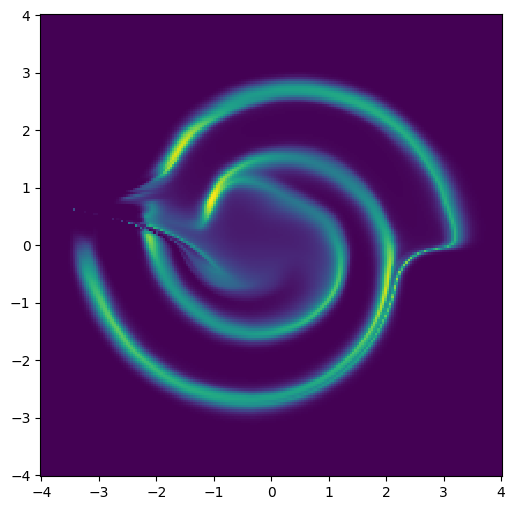

100%|██████████| 8000/8000 [07:07<00:00, 18.70it/s]


In [13]:
# Train model
num_epochs = 8000
batch_size = 2 ** 10
show_epoch = 800


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

for epoch in trange(num_epochs):
    optimizer.zero_grad()
    
    # Get training samples
    x = two_spirals(batch_size).to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (epoch + 1) % show_epoch == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(6, 6))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

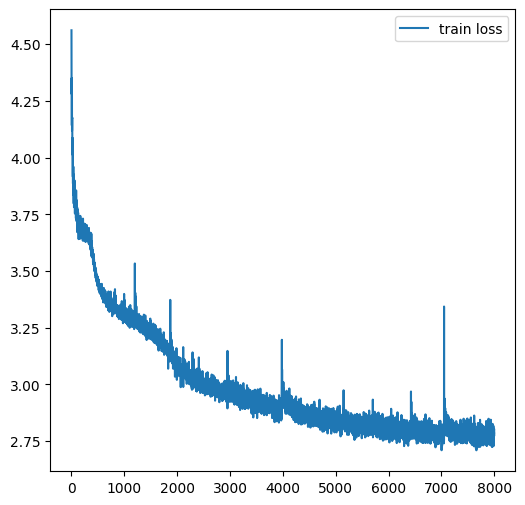

In [14]:
# Plot loss
plt.figure(figsize=(6, 6))
plt.plot(loss_hist, label='train loss')
# plt.yscale('log')
plt.legend()
plt.show()

This is our trained flow model!

Note that there might be a density filament connecting the two modes, which is due to an architectural limitation of normalizing flows, especially prominent in Real NVP. You can find out more about it in [this paper](https://proceedings.mlr.press/v151/stimper22a).

## Plotting and visualization

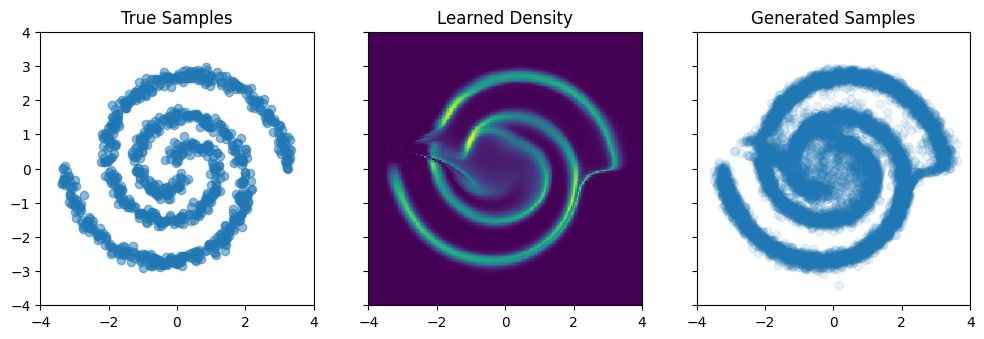

In [15]:
# # Plot target distribution
# f, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 8))

# log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
# prob = torch.exp(log_prob)
# prob[torch.isnan(prob)] = 0

# ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')

# ax[0].set_aspect('equal', 'box')
# ax[0].set_axis_off()
# ax[0].set_title('Target', fontsize=24)


fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

### Plot true samples
x_sample = two_spirals(1000)
ax[0].scatter(x_sample[:,0], x_sample[:,1], alpha=0.5)

ax[0].set_aspect('equal', 'box')
# ax[0].set_axis_off()
ax[0].set_title('True Samples')
ax[0].set_xlim(x_lim_plot[0], x_lim_plot[1])
ax[0].set_ylim(y_lim_plot[0], y_lim_plot[1])


### Plot learned distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='viridis')

ax[1].set_aspect('equal', 'box')
# ax[1].set_axis_off()
ax[1].set_title('Learned Density')
ax[1].set_xlim(x_lim_plot[0], x_lim_plot[1])
ax[1].set_ylim(y_lim_plot[0], y_lim_plot[1])


### Plot generated samples
samples_gen, log_prob_samples_gen = model.sample(10000)
samples_gen = samples_gen.detach().cpu().numpy()
# log_prob_samples_gen = log_prob_samples_gen.detach().cpu().numpy()
xs_sample_gen = samples_gen[:, 0]
ys_sample_gen = samples_gen[:, 1]

ax[2].scatter(xs_sample_gen, ys_sample_gen, alpha=0.1)

ax[2].set_aspect('equal', 'box')
# ax[2].set_axis_off()
ax[2].set_title('Generated Samples')
ax[2].set_xlim(x_lim_plot[0], x_lim_plot[1])
ax[2].set_ylim(y_lim_plot[0], y_lim_plot[1])

# plt.subplots_adjust(wspace=0.1)
plt.show()